## Exercise 4

In [9]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import * 
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [10]:
def moveTo(obj, device): 
    """ 
    obj: the python object to move to a device, or to move its
    ➥ contents to a device
    device: the compute device to move objects to 
    """
    if isinstance(obj, list): 
        return [moveTo(x, device) for x in obj] 
    elif isinstance(obj, tuple): 
        return tuple(moveTo(list(obj), device)) 
    elif isinstance(obj, set): 
        return set(moveTo(list(obj), device)) 
    elif isinstance(obj, dict): 
        to_ret = dict() 
        for key, value in obj.items(): 
            to_ret[moveTo(key, device)] = moveTo(value, device) 
        return to_ret 
    elif hasattr(obj, "to"): 
        return obj.to(device) 
    else: 
        return obj

In [11]:
import time

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch


In [12]:
import pandas as pd

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

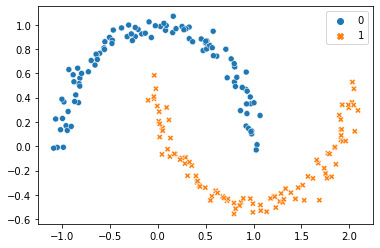

In [13]:
from sklearn.datasets import make_moons 
X, y = make_moons(n_samples=200, noise=0.05) 
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset)

In [14]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
testing_loader = DataLoader(test_dataset, batch_size=32)

from sklearn import metrics
def custom_auc(y_true, y_pred):
    # y_pred_resh = y_pred.reshape(-1)
    # y_true_resh = y_true.reshape(-1)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return auc


In [15]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30,  32),
    nn.Tanh(),
    nn.Linear(32,  64),
    nn.Tanh(),
    nn.Linear(64,  128),
    nn.Tanh(),
    nn.Linear(128,  256),
    nn.Tanh(),
    nn.Linear(256,  512),
    nn.Tanh(),
    nn.Linear(512,  1024),
    nn.Tanh(),
    nn.Linear(1024,  128),
    nn.Tanh(),
    nn.Linear(128,  32),
    nn.Tanh(),
    nn.Linear(32,  32),
    nn.Tanh(),
    nn.Linear(32, 2),
)

loss_func = nn.CrossEntropyLoss()
results_pd = train_simple_network(model, loss_func, training_loader, epochs=100, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score, 'AUC': custom_auc})


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 100%|██████████| 100/100 [03:22<00:00,  2.02s/it]


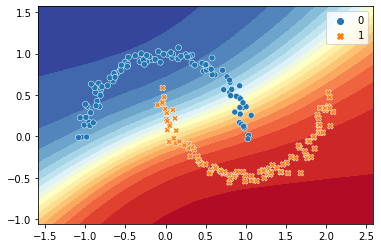

In [16]:
def visualize2DSoftmax(X, y, model, title=None): 
    x_min = np.min(X[:,0])-0.5 
    x_max = np.max(X[:,0])+0.5 
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5 
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij') 
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1))) 
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32)) 
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu) 
    ax = plt.gca() 
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax) 
    if title is not None: 
        ax.set_title(title)

visualize2DSoftmax(X, y, model)